In [470]:
import pandas as pd
import numpy as np

# Select Transactions from DB

In [471]:
import psycopg2 
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os


load_dotenv()


hostname=os.getenv("hostname")
database=os.getenv("database")
username=os.getenv("username")
pwd=os.getenv("pwd")
port_id=os.getenv("port_id")
host = os.getenv("host")


In [472]:
conn_string = f"postgresql://{username}:{pwd}@{host}:{port_id}/{database}"
db =  create_engine(url=conn_string)
# conn=db.connect()

transactions = pd.read_sql("SELECT * FROM transactions", db)

transactions.head()



,transaction_date,owner,ticker,asset_description,asset_type,type,amount,comment,senator,ptr_link,disclosure_date,id,senatorId
0,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,0,100
1,10/31/2022,Joint,CLF,Cleveland-Cliffs Inc. Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,1,100
2,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,2,100
3,10/28/2022,Joint,MSFT,Microsoft Corporation - Common Stock Option Ty...,Stock Option,Sale (Full),"$1,001 - $15,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,3,100
4,10/24/2022,Joint,MSFT,Microsoft Corporation - Common Stock,Stock,Purchase,"$15,001 - $50,000",--,Thomas H Tuberville,https://efdsearch.senate.gov/search/view/ptr/b...,11/10/2022,4,100


In [473]:
transactions['dt'] = pd.to_datetime(transactions['transaction_date'])
transactions = transactions.sort_values(by="dt")
earliestDate = transactions.dt.to_list()[0]
earliestDate

Timestamp('2012-06-14 00:00:00')

# Convert API Request to DataFrame

In [474]:
load_dotenv()
import requests
import json 
import asyncio


def requestFromEndpoint(ticker):
    #create endpoint
    apiKey = os.getenv('apiKey')
    endpoint =f"https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY_ADJUSTED&symbol={ticker}&apikey={apiKey}"

    response = requests.get(endpoint)
    responseText = response.text

    return responseText


def jsonToDataFrame(jsonData, ticker):
    # allWeeksData = jsonData['Weekly Time Series']
    allWeeksData = jsonData['Weekly Adjusted Time Series']
    allWeeks = list(allWeeksData.keys())

    #convert to df 
    firstWeek = allWeeks[0]
    firstWeekData =allWeeksData[firstWeek ]
    historicalPrices = pd.json_normalize(firstWeekData)
    historicalPrices['date'] = firstWeek

    historicalPrices = historicalPrices.head(0)

    for wk in allWeeks: 
        currentWeekData = allWeeksData[wk]
        currentFrame = pd.json_normalize(currentWeekData)
        currentFrame['date'] = wk
        historicalPrices = pd.concat([historicalPrices, currentFrame])


    # remove oldest values 
    historicalPrices['dt'] = pd.to_datetime(historicalPrices.date)
    historicalPrices = historicalPrices[historicalPrices['dt'] > earliestDate]


    #format frame
    # historicalPrices.rename(columns={'4. close': ticker}, inplace=True)
    historicalPrices.rename(columns={'5. adjusted close': ticker}, inplace=True)
    historicalPrices = historicalPrices[[ticker, 'date']]
    historicalPrices[ticker] = historicalPrices[ticker].astype(float)
    
    return historicalPrices


invalidTickerReturnSting = 'ticker invalid'
maxCallReturnString = 'call limit exceeded'



def requestToDataFrame(ticker):
    
    responseText = requestFromEndpoint(ticker)

    jsonData = json.loads(responseText)

    callsExceededMessage = 'Our standard API call frequency is 5 calls per minute and 500 calls per day'
    invalidTickerMessage = 'Invalid API call. Please retry or visit the documentation'
    
    jsonValue_initial = list(jsonData.values())[0]
    if invalidTickerMessage in jsonValue_initial:
        return  invalidTickerReturnSting
    if callsExceededMessage in jsonValue_initial:
        return maxCallReturnString
    
    return jsonToDataFrame(jsonData, ticker)



In [475]:
koFrame = requestToDataFrame("KO")
tslaFrame = requestToDataFrame("TSLA")
spyFrame = requestToDataFrame("SPY")

In [476]:
glFrame = requestToDataFrame("GOOGL")
# glFrame.head()


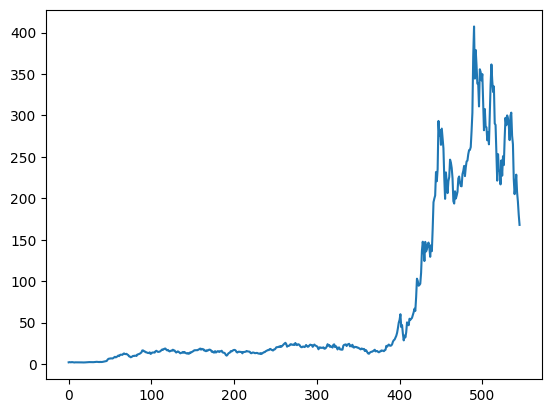

In [477]:
import matplotlib.pyplot as plt

tslaFrame = tslaFrame.sort_values(by="date")
plt.plot(np.array(tslaFrame['TSLA']), linestyle = 'solid')
plt.show()


data requests appear to be working correclty

# Establish Letter Ranges
this way we don't stick all stock data into one table


In [478]:
dateSer = transactions.groupby("ticker")['transaction_date'].min()
allTickers = list(dateSer.index)
allTickers[:5]

['--', '0QZI.IL', '3V64.TI', 'A', 'AA']

In [479]:
# dateSer.head()
tickerCount= len(allTickers)
print(f"unique tickers: {tickerCount}")
print("we can't create a table with over a thousand columns, it needs to be broken into smaller tables by leading letter")

unique tickers: 1199
we can't create a table with over a thousand columns, it needs to be broken into smaller tables by leading letter


In [480]:
import string

alphabet = (string.ascii_uppercase)
countList = [0 for i in alphabet]
letterCounts = dict(zip(alphabet, countList))
# letterCounts
for tick in allTickers: 
    tick = str(tick)
    leadingLetter = tick[0]

    if leadingLetter.isalpha():
        # print(tick)
        letterCounts[leadingLetter] = letterCounts[leadingLetter]+1

letterCounts

{'A': 105,
 'B': 65,
 'C': 112,
 'D': 47,
 'E': 51,
 'F': 50,
 'G': 46,
 'H': 42,
 'I': 52,
 'J': 15,
 'K': 28,
 'L': 46,
 'M': 63,
 'N': 47,
 'O': 19,
 'P': 72,
 'Q': 9,
 'R': 47,
 'S': 85,
 'T': 62,
 'U': 19,
 'V': 42,
 'W': 38,
 'X': 20,
 'Y': 4,
 'Z': 8}

In [481]:

columnLimit = 500
cumulativeSum = 0
rez = []
letterList = list(letterCounts.keys())
countList = list(letterCounts.values())

# for idx, value in enumerate(countList) :
for  value in countList :
    cumulativeSum+= value
    tableCount = (cumulativeSum//columnLimit)+1
    rez.append([value, cumulativeSum, tableCount ])
    

letterCountsNew = dict(zip(letterList, rez))
letterCountsNew



{'A': [105, 105, 1],
 'B': [65, 170, 1],
 'C': [112, 282, 1],
 'D': [47, 329, 1],
 'E': [51, 380, 1],
 'F': [50, 430, 1],
 'G': [46, 476, 1],
 'H': [42, 518, 2],
 'I': [52, 570, 2],
 'J': [15, 585, 2],
 'K': [28, 613, 2],
 'L': [46, 659, 2],
 'M': [63, 722, 2],
 'N': [47, 769, 2],
 'O': [19, 788, 2],
 'P': [72, 860, 2],
 'Q': [9, 869, 2],
 'R': [47, 916, 2],
 'S': [85, 1001, 3],
 'T': [62, 1063, 3],
 'U': [19, 1082, 3],
 'V': [42, 1124, 3],
 'W': [38, 1162, 3],
 'X': [20, 1182, 3],
 'Y': [4, 1186, 3],
 'Z': [8, 1194, 3]}

so, one table for each of the letter ranges 'A-G', 'H-R', 'S-Z' 

In [482]:
string.ascii_uppercase

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [483]:
AGLetterRange =  'ABCDEFG'
HRLetterRange  = 'HIJKLMNOPQR'
SZLetterRange  = 'STUVWXYZ'

In [484]:
fillerFrame = requestToDataFrame('SPY')
fillerFrame.tail()

,SPY,date
0,111.7808,2012-07-13
0,111.5667,2012-07-06
0,112.0690,2012-06-29
0,109.8951,2012-06-22
0,110.4550,2012-06-15


In [485]:
fillerFrame.columns=['deleteMe', 'date']

# ensure each starting dataframe always has more columns than the dataframe is merging with
fillerFrame['deleteMeToo'] = fillerFrame['deleteMe']

fillerFrame.tail()

,deleteMe,date,deleteMeToo
0,111.7808,2012-07-13,111.7808
0,111.5667,2012-07-06,111.5667
0,112.0690,2012-06-29,112.0690
0,109.8951,2012-06-22,109.8951
0,110.4550,2012-06-15,110.4550


In [486]:
AGFrame = fillerFrame
HRFrame = fillerFrame
SZFrame = fillerFrame 



In [331]:
# AGFrame

# Create Merging Function 

In [487]:
print(tslaFrame.merge(koFrame, how='left', on='date').shape)
print("NOTE, all week end periods match across requests. so let's make a function for merging ")

(546, 3)
NOTE, all week end periods match across requests. so let's make a function for merging 


In [488]:
def mergeFrames(frame1, frame2):
    rows1 = frame1.shape[1]
    rows2 = frame2.shape[1]
    
    # always merge left against the frame with more columns 
    if rows1 >= rows2:
        largeFrame, shortFrame = frame1, frame2
    else: 
        largeFrame, shortFrame = frame2, frame1
    
    rez = largeFrame.merge(shortFrame, how='left', on='date')

    return rez


temp = mergeFrames(koFrame, tslaFrame)
temp = mergeFrames(temp, spyFrame)
temp.tail()

,KO,date,TSLA,SPY
541,28.0166,2012-07-13,2.2833,111.7808
542,28.3320,2012-07-06,2.0660,111.5667
543,28.3465,2012-06-29,2.0860,112.0690
544,27.1682,2012-06-22,2.2523,109.8951
545,27.5851,2012-06-15,1.9940,110.4550


# Harvest Data and and Post to the appropriate Dataframe
* stay under the call limit per minute
* make fetches until the daily call limit is reached 
* post data to dataframes 

In [489]:
import time

callLimitTimeout = 60/5
callsExecutedCount = 0
isDailyCallLimitReached = False
currentFrameString = 'hello'
invalidTickers = []
unmergedTickers =[]
attemptedTickers = []
connectionErrorTickers = []

callsExecutedYesterday = 0

remainingTickers = allTickers.copy()


In [490]:


# this function must be one once per day to harvest all stock data without breaking daily call limit
def harvestStockData():
    global callLimitTimeout
    global callsExecutedCount 
    global isDailyCallLimitReached 
    global currentFrameString 
    global invalidTickers 
    global unmergedTickers 
    global attemptedTickers
    global connectionErrorTickers

    global AGFrame
    global HRFrame
    global SZFrame


    remainingTickers = list(filter(lambda tick: tick not in attemptedTickers, allTickers))

    
    for currentTicker in remainingTickers:

        attemptedTickers.append(currentTicker)
        #stay under minute call limit 
        time.sleep(callLimitTimeout)
        callsExecutedCount+=1

        print(f"attempting ticker: {currentTicker}", end="\r")

        currentFrame = 'starting value'

        try:
            currentFrame = requestToDataFrame(currentTicker)
        except ConnectionError:
            connectionErrorTickers.append(currentTicker)
            continue           


        currentFrameString = str(currentFrame)[:100]

        if currentFrameString == invalidTickerReturnSting:
            invalidTickers.append(currentTicker)
            continue 
        
        if currentFrameString == maxCallReturnString:
            # pick up where you left off yesterday 
            #exit loop if daily call limit is exceeded, return statistics 
            print(f"""calll limit exceeded \n 
        #     calls executed: {callsExecutedCount} \n 
        #     last called ticker: {currentTicker}""")
            break

        tickerLeadingLetter = currentTicker[0]

        if tickerLeadingLetter in AGLetterRange:
            AGFrame= mergeFrames(AGFrame, currentFrame)
        elif tickerLeadingLetter in HRLetterRange:
            HRFrame= mergeFrames(HRFrame, currentFrame)
        elif tickerLeadingLetter in SZLetterRange:
            SZFrame  = mergeFrames(SZFrame, currentFrame)
        else:
            unmergedTickers.append(currentTicker)

    print("function execution complete")
    return 'finished'
    

In [491]:
# running the first day 
harvestStockData()

IndexError: list index out of range

In [ ]:
# running the second day 
# harvestStockData()

In [492]:
allTickers[-10:]


['ZAYO', 'ZBH', 'ZIOP', 'ZM', 'ZMH', 'ZNGA', 'ZNGA.SW', 'ZTS', '^MWE', '^RGP']

alright! function ran all night with no problems. let's confirm we have our data

In [494]:
for frame in [AGFrame, HRFrame, SZFrame]:
    print(frame.shape)



(546, 450)
(546, 420)
(546, 265)


In [495]:
HRFrame.head()

,deleteMe,date,deleteMeToo,HACK,HAL,HALO,HAS,HASI,HBAN,HBI,...,RRTS,RSP,RSPP,RTH,RTN,RTX,RYAAY,RYAM,RYN,RYT
0,394.59,2022-11-21,394.59,45.33,36.13,53.29,59.1500,30.81,14.94,6.6100,...,2.0400,144.47,NaN,167.87,NaN,96.2000,74.99,7.39,35.70,252.69
1,396.03,2022-11-18,396.03,45.23,36.71,52.94,59.5200,31.18,14.89,6.6589,...,2.1483,144.53,NaN,167.85,NaN,95.3600,73.98,7.65,35.51,255.02
2,398.51,2022-11-11,398.51,45.96,38.74,53.97,63.4100,33.05,14.97,7.5976,...,2.2100,146.08,NaN,166.77,NaN,93.1083,78.18,7.09,35.65,258.51
3,376.35,2022-11-04,376.35,42.60,38.48,46.59,62.1900,27.48,15.38,6.8153,...,2.3000,137.91,NaN,158.24,NaN,94.6692,69.05,7.14,32.88,234.69
4,389.02,2022-10-28,389.02,47.13,35.95,48.24,65.0323,27.29,15.11,7.0402,...,2.2700,140.18,NaN,163.99,NaN,94.5300,67.86,4.36,34.11,247.62


In [496]:
for frame in [AGFrame, HRFrame, SZFrame]:
    for col in frame:
        if 'deleteMe' in col:
            frame.drop([col], axis=1, inplace=True)
    print(frame.shape)

(546, 448)
(546, 418)
(546, 263)


In [424]:
AGFrame.head()

,date,A,AA,AAGIY,AAL,AAN,AAON,AAPL,AAT,ABB,...,GRMN,GRUB,GS,GSIMX,GSK,GSMYX,GSSC,GTCSX,GTX,GWW
0,2022-11-15,148.00,49.21,38.2600,14.61,10.76,80.24,150.04,28.24,31.31,...,NaN,NaN,NaN,17.03,NaN,20.25,NaN,34.57,7.50,NaN
1,2022-11-11,148.31,47.66,37.6602,14.88,11.44,78.02,149.70,28.58,31.58,...,93.76,NaN,385.17,16.92,31.58,20.03,57.79,34.46,7.43,586.52
2,2022-11-04,136.08,42.40,33.7600,14.11,9.71,65.81,138.38,28.25,28.65,...,86.53,NaN,357.91,16.56,32.99,18.92,55.37,32.72,7.51,593.64
3,2022-10-28,138.77,39.49,29.5800,14.00,10.33,65.15,155.74,27.44,28.02,...,88.49,NaN,341.82,16.33,33.27,19.69,56.39,33.12,6.79,575.88
4,2022-10-21,129.88,41.06,33.9800,13.71,8.71,56.25,147.27,26.25,27.41,...,82.77,NaN,325.10,16.15,31.87,18.58,53.27,31.28,5.78,519.68


Looks like we've got 3 beautiful DataFrames

# Post DataFrames to Database

In [497]:
def postDataFrameDB(frame , dbTableName):
    try:
        conn_string = f"postgresql://{username}:{pwd}@{host}:{port_id}/{database}"
        db =  create_engine(url=conn_string)
        conn=db.connect()

        frame.to_sql(dbTableName, con=conn, if_exists='replace', index=False)
        print("posted successfully")

    except Exception as err:
        print(err)
    finally: 
        if cur is not None: 
            cur.close()
        if conn is not None: 
            conn.close()
    

In [498]:
# Before posting, lets add the spy and nasdaq to each dataframe 

spyFrame = requestToDataFrame("SPY")
spyFrame.head()


,SPY,date
0,394.59,2022-11-21
0,396.03,2022-11-18
0,398.51,2022-11-11
0,376.35,2022-11-04
0,389.02,2022-10-28


In [499]:
nasFrame = requestToDataFrame("NDAQ")
nasFrame.head()

,NDAQ,date
0,65.96,2022-11-21
0,65.52,2022-11-18
0,66.40,2022-11-11
0,61.90,2022-11-04
0,62.28,2022-10-28


In [500]:
indexFrame = mergeFrames(nasFrame, spyFrame)
indexFrame.head()


,NDAQ,date,SPY
0,65.96,2022-11-21,394.59
1,65.52,2022-11-18,396.03
2,66.40,2022-11-11,398.51
3,61.90,2022-11-04,376.35
4,62.28,2022-10-28,389.02


In [501]:
AGFrame = mergeFrames(AGFrame, indexFrame)
HRFrame = mergeFrames(HRFrame, indexFrame)
SZFrame = mergeFrames(SZFrame, indexFrame)


'NDAQ' in AGFrame.columns

True

In [502]:
postDataFrameDB(AGFrame, 'historical_pricesA_G')

posted successfully


In [503]:
postDataFrameDB(HRFrame, 'historical_pricesH_R')

posted successfully


In [504]:
postDataFrameDB(SZFrame, 'historical_pricesS_Z')


posted successfully


In [505]:
print(unmergedTickers, connectionErrorTickers)
print("no errors here, that's good news")


[] []
no errors here, that's good news


In [506]:
invalidPct = round(len(invalidTickers)/len(allTickers),3)*100
print(f"only {invalidPct}% of stock tickers were invalid")


only 5.8999999999999995% of stock tickers were invalid


In [507]:
# saving exteranally so data is not lost

HRFrame.to_csv("./CSV Files/HRFrame.csv")
AGFrame.to_csv("./CSV Files/AGFrame.csv")
SZFrame.to_csv("./CSV Files/SZFrame.csv")